In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping


In [2]:
# load the df
final_df = pd.read_csv("the_real_final_df.csv")

# view the df
final_df.head()

,gameid,participantid,champion,result,year,playerid,side,total_games,total_wins,total_kills,...,OppPick_Yone,OppPick_Yorick,OppPick_Yuumi,OppPick_Zac,OppPick_Zed,OppPick_Zeri,OppPick_Ziggs,OppPick_Zilean,OppPick_Zoe,OppPick_Zyra
0,TREU/1001490056,1,Nautilus,1,2017,oe:player:48e06b61418cf7d3391acd04e2462a6,Blue,214,107,528,...,0,0,0,0,0,0,0,0,0,0
1,TREU/1001490139,1,Nautilus,1,2017,oe:player:48e06b61418cf7d3391acd04e2462a6,Blue,214,107,528,...,0,0,0,0,0,0,0,0,0,0
2,TREU/1001490173,1,Nautilus,1,2017,oe:player:48e06b61418cf7d3391acd04e2462a6,Blue,214,107,528,...,0,0,0,0,0,0,0,0,0,0
3,ESPORTSTMNT02/90212,1,Nautilus,1,2017,oe:player:48e06b61418cf7d3391acd04e2462a6,Blue,214,107,528,...,0,0,0,0,0,0,0,0,0,0
4,ESPORTSTMNT02/90221,6,Nautilus,1,2017,oe:player:48e06b61418cf7d3391acd04e2462a6,Red,214,107,528,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# drop the columns that have been one hot encoded and drop gameid (for modeling process)
new_df = final_df.drop(
    columns=['gameid', 'champion', 'playerid', 'side', 'pick2', 'pick3', 'pick4','participantid',
       'pick5', 'opp_pick1', 'opp_pick2', 'opp_pick3', 'opp_pick4',
       'opp_pick5']
)

In [4]:
df = new_df

In [5]:
scaler = StandardScaler()

# Select numerical columns that are not one-hot encoded (having more than two unique values)
non_binary_numerical_cols = [col for col in df.columns if df[col].nunique() > 2]

# Normalize these selected columns
df[non_binary_numerical_cols] = scaler.fit_transform(df[non_binary_numerical_cols])


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump

# Split the data into train, validation, and test sets first
X = df.drop("result", axis=1)
y = df["result"]

# 70% train, 20% validation, and 10% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Standardize the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit PCA on the scaled training data
pca = PCA(n_components=0.95)  # retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Now, X_train_pca, X_val_pca, and X_test_pca can be used for training and evaluation

dump(scaler, 'scaler.joblib')

# Save the PCA model
dump(pca, 'pca.joblib')


['pca.joblib']

**Model Goes Here**

In [8]:
def create_model(neurons=32, learning_rate=0.001, extra_layers=0):
    model = Sequential()
    # Adjust input_dim to match the number of PCA components
    model.add(Dense(neurons, input_dim=X_train_pca.shape[1], activation='relu'))

    # Add extra hidden layers based on the extra_layers parameter
    for _ in range(extra_layers):
        model.add(Dense(neurons, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
model = KerasClassifier(model=create_model, verbose=0, random_state=42)

param_grid = {
    'model__neurons': [16, 32, 64, 128],  # expanded range of neurons
    'model__learning_rate': [0.001, 0.005, 0.01, 0.05],  # finer range around lower values
    'model__extra_layers': [0, 1, 2, 3]  # testing more layers
}


In [10]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_pca, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.617384 using {'model__extra_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128}
0.613123 (0.001716) with: {'model__extra_layers': 0, 'model__learning_rate': 0.001, 'model__neurons': 16}
0.613258 (0.002301) with: {'model__extra_layers': 0, 'model__learning_rate': 0.001, 'model__neurons': 32}
0.613842 (0.001796) with: {'model__extra_layers': 0, 'model__learning_rate': 0.001, 'model__neurons': 64}
0.612350 (0.000781) with: {'model__extra_layers': 0, 'model__learning_rate': 0.001, 'model__neurons': 128}
0.606036 (0.000346) with: {'model__extra_layers': 0, 'model__learning_rate': 0.005, 'model__neurons': 16}
0.598865 (0.004226) with: {'model__extra_layers': 0, 'model__learning_rate': 0.005, 'model__neurons': 32}
0.586321 (0.004041) with: {'model__extra_layers': 0, 'model__learning_rate': 0.005, 'model__neurons': 64}
0.578197 (0.005290) with: {'model__extra_layers': 0, 'model__learning_rate': 0.005, 'model__neurons': 128}
0.594382 (0.003985) with: {'model__extra_layers'

In [12]:
from sklearn.metrics import roc_auc_score
best_model = grid_result.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc_score}")

Test AUC: 0.6682463511458125


AUC: 0.668
F1 Score: 0.660


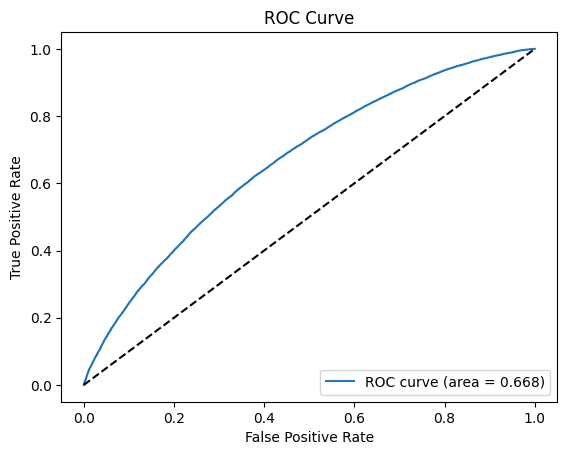

In [13]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
# Predict probabilities and class labels for the test set
y_probs = best_model.predict_proba(X_test_pca)[:, 1]  # Get the probability of the positive class
y_pred = best_model.predict(X_test_pca)

# Calculate AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC: {:.3f}".format(auc))

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {:.3f}".format(f1))

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from joblib import dump
dump(best_model, 'model.joblib')

['model.joblib']